In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
from itertools import combinations
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output 
from IPython.display import HTML

In [2]:
def plot(X):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X[:,0], X[:,1])

    for i,x in enumerate(X):
        ax.text(*tuple(x*1.02), str(i))

    ax.grid("both")
    ax.axis([-2,2,-2,2])
    return fig, ax

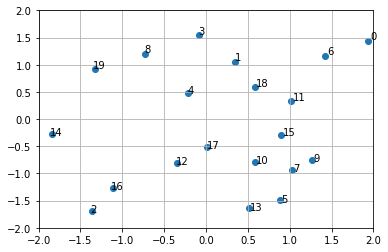

In [10]:
X = np.asarray([
    [0, np.sqrt(3)],
    [0, -np.sqrt(3)],
    [1, 0],
    [-1, 0]
])
X = (np.random.rand(20, 2)-.5)*4
plot(X)
plt.show()

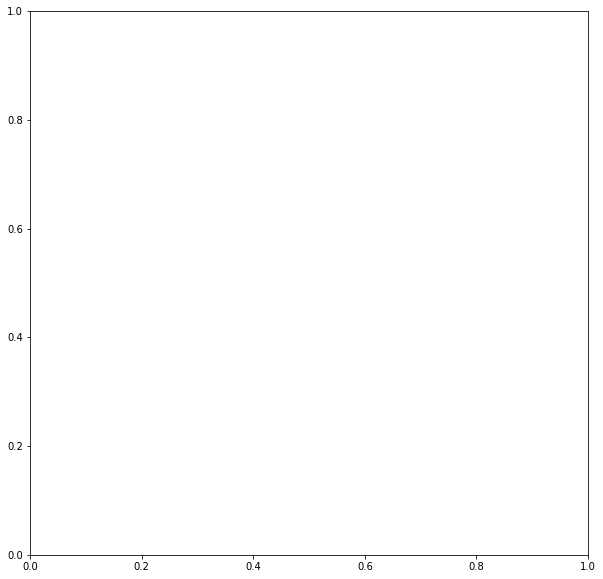

In [12]:
def A(a,b,c,radius):
    gamma = np.arccos((a**2 + b**2 - c**2)/(2*a*b))
    alpha = np.arccos((b**2 + c**2 - a**2)/(2*b*c))
    beta  = np.pi - gamma - alpha

    sector_areas = np.asarray(list(map(
        lambda theta : .5*theta*(radius**2),
        [gamma, alpha, beta]
    )))

    lengths = np.asarray([a,b,c])/2
    theta = np.arccos(lengths/radius)*2 # theta for all 3 lenses
    lens_areas = (radius**2)*(theta - np.sin(theta))/2

    return sector_areas.sum() - lens_areas.sum()
#-------------
def trielle(sides, radius):
    #---- compute sector areas
    sectors = np.zeros(sides.shape)
    sectors[:,0] = np.arccos(
        (sides[:,0]**2 + sides[:,1]**2 - sides[:,2]**2)/(2*sides[:,0]*sides[:,1])
    )
    sectors[:,1] = np.arccos(
        (sides[:,1]**2 + sides[:,2]**2 - sides[:,0]**2)/(2*sides[:,1]*sides[:,2])
    )
    sectors[:,2] = np.pi - sectors[:,0] - sectors[:,1]
    sectors *= .5
    sectors *= radius**2

    #---- compute lens areas, lenses
    lenses = sides*.5
    lenses /= radius
    lenses = np.arccos(lenses)
    lenses *= 2
    lenses -= np.sin(lenses)
    lenses *= radius**2
    lenses /= 2
    
    return sectors.sum(axis = 1) - lenses.sum(axis = 1)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()

D = spatial.distance_matrix(X,X)

kdtree = spatial.KDTree(X)

r_def = np.linspace(0,1,300)

def animate(i):
    clear_output(wait=True)
    print(i)
    ax.clear()
    
    ax.axis([-3,3,-3,3])
    ax.grid("both")
    
    #--- plot vertices
    ax.scatter(X[:,0], X[:,1])

    for idx,x in enumerate(X):
        ax.text(*tuple(x*1.1), str(idx), zorder = np.inf)
        
    #--- plot circles
    for x in X:
        circle = plt.Circle(x, r_def[i], ls = "--", color = "black", fill = False, alpha = .333)
        ax.add_patch(circle)

    pairs = set(kdtree.query_pairs(r_def[i]*2))
    
    #--- plot lines
    for pair in pairs:
        p0, p1 = X[pair[0],:], X[pair[1],:]
        ax.plot(
            [p0[0],p1[0]],
            [p0[1],p1[1]],
            "-",
            color = "black",
            #alpha = .333
        )
    
    #--- plot triangles
    sides = list() # vectorized
    for tri in combinations(list(range(X.shape[0])), 3):
        boundary = list(combinations(tri, 2))    
        if len(pairs.intersection(set(boundary))) == 3:
            sides.append((tri, [ float(D[f,t]) for f,t in boundary ]))
            
    if len(sides) > 0:
        sides = np.asarray(sides)

        a1 = trielle(sides[:,1], r_def[i])
        a2 = trielle(sides[:,1], r_def[i]*1.0001)

        for tri, side in sides[a2 < a1, :]:
            ax.add_patch(plt.Polygon(X[tri.astype(int),:], color = "black", alpha = .1))
    
anim = FuncAnimation(fig, animate, interval = 500, frames = len(r_def))

In [13]:
HTML(anim.to_html5_video())

299
